In [1]:
from xdesign import *
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
import os

`polytope` failed to import `cvxopt.glpk`.
Will use `scipy.optimize.linprog`.


# Generate the Phantom

Generate a simulated phantom using XDesign in order to estimate reconstruction quality for each of the three scanning paradigms.

In [2]:
np.random.seed(0)
phantom = DogaCircles(n_sizes=7, size_ratio=10/16, n_shuffles=16)
phantom.radii

array([[ 0.01953,  0.00298,  0.03125,  0.01221,  0.00763,  0.05   ,
         0.00477],
       [ 0.05   ,  0.00763,  0.00298,  0.03125,  0.01953,  0.00477,
         0.01221],
       [ 0.01221,  0.05   ,  0.01953,  0.00763,  0.00477,  0.03125,
         0.00298],
       [ 0.00763,  0.03125,  0.01221,  0.00477,  0.00298,  0.01953,  0.05   ],
       [ 0.00298,  0.01221,  0.00477,  0.05   ,  0.03125,  0.00763,
         0.01953],
       [ 0.03125,  0.00477,  0.05   ,  0.01953,  0.01221,  0.00298,
         0.00763],
       [ 0.00477,  0.01953,  0.00763,  0.00298,  0.05   ,  0.01221,
         0.03125]])

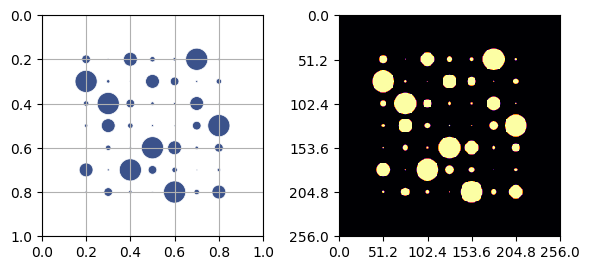

In [3]:
size = 256
truth = sidebyside(phantom, size)
tif.imsave('./data/doga_recons/truth_{}.tiff'.format(size), truth.T.astype('float32'))
plt.show()

# Generate sinograms

Create sinograms for variety of parameters for each of the three different acquisition schemes: raster, meta-raster, and random meta-raster.

In [4]:
probe_width = 1/256 # The width of the probe in cm
num_angles = [11, 53, 101, 251, 499, 751, 1009] # the number of projection angles
pixel_fractions = [1.] # the pixel size compared to the beam width
gap_fractions = [1./2, 1./4, 1./8, 1./16] # the fraction of space covered by the beam
# (gap_fractions must be a factor of probe_width)

In [5]:
def grams():
    np.random.seed(0)
    pool=None
    for angle in num_angles:
        for pix in pixel_fractions:
            for gap in gap_fractions:
                num_steps = int(gap / probe_width)
                file = './data/doga_grams/rmeta/{}_{}_{}.npy'.format(angle, num_steps, gap)
                if not os.path.exists(file):
                    print(file)
                    procedure_raster = raster_scan(angle, num_steps, width_fraction=gap)
                    procedure_meta = raster_scan(angle, num_steps, width_fraction=gap, nmeta=0, random=False)
                    procedure_rmeta = raster_scan(angle, num_steps, width_fraction=gap, nmeta=0, random=True)

                    chunk = int(angle)
                    gram_raster, prb0 = calculate_gram(procedure_raster, angle*num_steps, phantom, pool=pool, chunksize=chunk)
                    gram_meta, prb1  = calculate_gram(procedure_meta, angle*num_steps, phantom, pool=pool, chunksize=chunk)
                    gram_rmeta, prb2 = calculate_gram(procedure_rmeta, angle*num_steps, phantom, pool=pool, chunksize=chunk)

                    gram_raster = -np.log(gram_raster)
                    gram_meta = -np.log(gram_meta)
                    gram_rmeta = -np.log(gram_rmeta)

                    np.save('./data/doga_grams/raster/{}_{}_{}.npy'.format(angle, num_steps, gap), [gram_raster, prb0])
                    np.save('./data/doga_grams/meta/{}_{}_{}.npy'.format(angle, num_steps, gap), [gram_meta, prb1])
                    np.save('./data/doga_grams/rmeta/{}_{}_{}.npy'.format(angle, num_steps, gap), [gram_rmeta, prb2])

                    plt.figure()
                    plt.subplot(1,3,1)
                    plt.imshow(gram_raster.reshape(angle, num_steps))
                    plt.subplot(1,3,2)
                    plt.imshow(gram_meta.reshape(angle, num_steps))
                    plt.subplot(1,3,3)
                    plt.imshow(gram_rmeta.reshape(angle, num_steps))
                    plt.show()
                
# grams()

In [6]:
def plot_grams():
    np.random.seed(0)
    pool=None
    for angle in num_angles:
        for pix in pixel_fractions:
            for gap in gap_fractions:
                num_steps = int(gap / probe_width)

                gram_raster, prb0 = np.load('./data/doga_grams/raster/{}_{}_{}.npy'.format(angle, num_steps, gap))
                gram_meta, prb1 = np.load('./data/doga_grams/meta/{}_{}_{}.npy'.format(angle, num_steps, gap))
                gram_rmeta, prb2 = np.load('./data/doga_grams/rmeta/{}_{}_{}.npy'.format(angle, num_steps, gap))

    #             fig = plt.figure(figsize=(3 * 8.85/2.54, 8.85/2.54), dpi=400)
                plt.figure()
                plt.subplot(1,3,1)
                plt.imshow(gram_raster.reshape(angle, num_steps), interpolation='none')
                plt.subplot(1,3,2)
                plt.imshow(gram_meta.reshape(angle, num_steps), interpolation='none')
                plt.subplot(1,3,3)
                plt.imshow(gram_rmeta.reshape(angle, num_steps), interpolation='none')
                plt.suptitle("Grams for {} measures and {} steps".format(total_measures, num_steps))
                plt.show()

# plot_grams()

# Reconstruct

Reconstruct the phantom from the generated sinograms. Use SIRT.

In [7]:
niter = 50 # the number of SIRT iterations to use

In [8]:
def makeit(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


def recons():
    np.random.seed(0)
    pool=None
    for angle in num_angles:
        for gap in gap_fractions:
            num_steps = int(gap / probe_width)
            file = './data/doga_recons/rmeta/{}/{}_{}_{}_{}.npy'.format(niter, size, angle, num_steps, gap)
            if not os.path.exists(file):
                print(file)
                gram_raster, prb0 = np.load('./data/doga_grams/raster/{}_{}_{}.npy'.format(angle, num_steps, gap))
                gram_meta, prb1 = np.load('./data/doga_grams/meta/{}_{}_{}.npy'.format(angle, num_steps, gap))
                gram_rmeta, prb2 = np.load('./data/doga_grams/rmeta/{}_{}_{}.npy'.format(angle, num_steps, gap))

#                 rec0 = np.load('./data/doga_recons/raster/{}_{}_{}.npy'.format(angle, num_steps, gap))
#                 rec1 = np.load('./data/doga_recons/meta/{}_{}_{}.npy'.format(angle, num_steps, gap))
#                 rec2 = np.load('./data/doga_recons/rmeta/{}_{}_{}.npy'.format(angle, num_steps, gap))

                rec0 = np.zeros((size, size))
                rec1 = np.zeros((size, size))
                rec2 = np.zeros((size, size))

                rec0 = sirt(prb0, gram_raster, rec0, niter=niter)
                rec1 = sirt(prb1, gram_meta, rec1, niter=niter)
                rec2 = sirt(prb2, gram_rmeta, rec2, niter=niter)

                makeit('./data/doga_recons/raster/{}'.format(niter))
                makeit('./data/doga_recons/meta/{}'.format(niter))
                makeit('./data/doga_recons/rmeta/{}'.format(niter))

                
                np.save('./data/doga_recons/raster/{}/{}_{}_{}_{}.npy'.format(niter, size, angle, num_steps, gap), rec0)
                np.save('./data/doga_recons/meta/{}/{}_{}_{}_{}.npy'.format(niter, size, angle, num_steps, gap), rec1)
                np.save('./data/doga_recons/rmeta/{}/{}_{}_{}_{}.npy'.format(niter, size, angle, num_steps, gap), rec2)

                print(np.all(rec0 == rec1))

                fig = plt.figure(figsize=(3 * 8.85/2.54, 8.85/2.54), dpi=400)
                plt.subplot(1,3,1)
                plt.imshow(rec0)
                plt.subplot(1,3,2)
                plt.imshow(rec1)
                plt.subplot(1,3,3)
                plt.imshow(rec2)
                plt.suptitle("{} iter SIRT with {} steps and {} pix".format(niter, num_steps, size))

#                 plt.savefig('./figures/{}_recon_comparison_{}.png'.format(angle, niter), format='png',
#                 transparent=True, bbox_inches=None, pad_inches=0,
#                 frameon=False)

                plt.show()

# recons()

# Figure 6 and Figure 7

Plot the reconstructions of DogaCircles for various parameters.

In [9]:
def Figure6():
    """Plot the reconstructions of DogaCircles for each acquisition paradigm
    as a function of the step size to beam size ratio. Hold the number of
    rotations constant at 101.
    """
    fig3 = plt.figure(dpi=400)
    i = 1
    for method in ['raster', 'meta', 'rmeta']:
        for gap in [1./2, 1./4, 1./8, 1./16]:
            num_steps = int(gap / probe_width)
            
            plt.subplot(3,4,i)
            rec1 = np.load('./data/doga_recons/{}/{}/{}_{}_{}_{}.npy'.format(method, niter, size, 101, num_steps, gap))
            rec1[np.isnan(rec1)] = 1
            plt.imshow(rec1, interpolation=None)
            
            plt.ylabel(method)
            plt.xlabel(1/gap)
            i += 1

    plt.suptitle("Figure 6")
    plt.tight_layout()
    plt.show()


def Figure7():
    """Plot the reconstructions of DogaCircles for each scanning paradigm as a function of
    number of rotation angles. Hold the step size to beam size ratio as 8."""
    fig4 = plt.figure(dpi=400)
    i = 1
    for method in ['raster', 'meta', 'rmeta']:
        for angle in [11, 101, 499, 1009]:
            gap = 1./8
            num_steps = int(gap / probe_width)
            
            plt.subplot(3,4,i)
            rec1 = np.load('./data/doga_recons/{}/{}/{}_{}_{}_{}.npy'.format(method, niter, size, angle, num_steps, gap))
            rec1[np.isnan(rec1)] = 1
            plt.imshow(rec1, interpolation=None)
            
            plt.ylabel(method)
            plt.xlabel(angle)
            i += 1
    plt.suptitle("Figure 7")
    plt.tight_layout()
    plt.show()
    
# Figure6()
# Figure7()

# Quality Metrics

Mean MS-SSIM quality ratings for each reconstruction in Fig 6 and Fig 7

In [10]:
for method in ['raster', 'meta', 'rmeta']:
    for gap in [1./2, 1./4, 1./8, 1./16]:
        angle = 101

        num_steps = int(gap / probe_width)
        rec1 = np.load('./data/doga_recons/{}/{}/{}_{}_{}_{}.npy'.format(method, niter, size, angle, num_steps, gap))
        rec1[np.isnan(rec1)] = 1

        nlev=6
        iq = ImageQuality(truth[64:192,64:192], rec1.T[64:192,64:192])
        iq.compute_quality(nlevels=nlev, method='MSSSIM')
        print(method, gap, np.mean(iq.mets))

raster 0.5 0.59540999903
raster 0.25 0.473755212714
raster 0.125 0.346545400045
raster 0.0625 0.192250296788
meta 0.5 0.57192200172
meta 0.25 0.471016000136
meta 0.125 0.341384866523
meta 0.0625 0.248720544623
rmeta 0.5 0.577866796881
rmeta 0.25 0.471882002264
rmeta 0.125 0.332192529505
rmeta 0.0625 0.262433902461


In [11]:
for method in ['raster', 'meta', 'rmeta']:
    for angle in [11, 101, 499, 1009]:
        gap = 1./8

        num_steps = int(gap / probe_width)
        rec1 = np.load('./data/doga_recons/{}/{}/{}_{}_{}_{}.npy'.format(method, niter, size, angle, num_steps, gap))
        rec1[np.isnan(rec1)] = 1

        nlev=6
        iq = ImageQuality(truth[64:192,64:192], rec1.T[64:192,64:192])
        iq.compute_quality(nlevels=nlev, method='MSSSIM')
        # print(iq.scale) # The scale of features for each quality measure
        print(method, angle, np.mean(iq.mets))

raster 11 0.0932631510626
raster 101 0.346545400045
raster 499 0.413040001591
raster 1009 0.413891844126
meta 11 0.101679092821
meta 101 0.341384866523
meta 499 0.514352506901
meta 1009 0.67055770871
rmeta 11 0.094542729934
rmeta 101 0.332192529505
rmeta 499 0.556017305991
rmeta 1009 0.621928240055


# Quality survey across two parameters

Plot a contour of the reconstruction quality of DogaCircles for step size
and number of angles for each method.

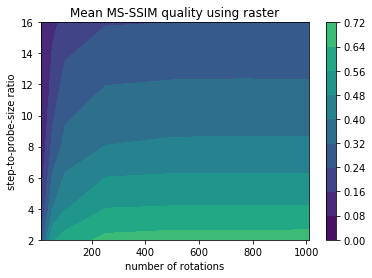

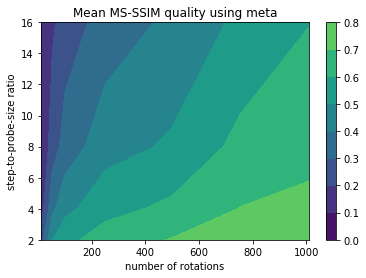

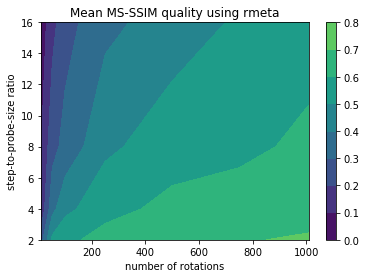

In [12]:
for method in ['raster', 'meta', 'rmeta']:
    
    grid = np.zeros([4, 7])
    X,Y = np.meshgrid(num_angles, gap_fractions)
    
    for col, angle in enumerate(num_angles):
        for row, gap in enumerate(gap_fractions):
            num_steps = int(gap / probe_width)

            rec1 = np.load('./data/doga_recons/{}/{}/{}_{}_{}_{}.npy'.format(method, niter, size, angle, num_steps, gap))
            rec1[np.isnan(rec1)] = 1
            nlev=6
            iq = ImageQuality(truth[64:192,64:192], rec1.T[64:192,64:192])
            iq.compute_quality(nlevels=nlev, method='MSSSIM')
            meaniq = np.mean(iq.mets)
            grid[row, col] = meaniq
    plt.figure()
    plt.contourf(X, 1./Y, grid)
    plt.title("Mean MS-SSIM quality using {}".format(method))
    plt.ylabel('step-to-probe-size ratio')
    plt.xlabel('number of rotations')
    plt.clim([0,1])
    plt.colorbar()
    plt.show()